In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating the model

The model is created using the `UlamModel` class.
This class is meant to be closely tied to stan, and as such it will generate a stan file which can be easily inspected for errors.
You can even use this package as a starting point for a stan model which you can later edit.
You can either give an explict stan file name or let Ulam generate unique file name automatically.

The model must be defined in a context because that way one ensures some setup and some cleanup is done before and after the python functions generate the model statements.

Not all comparison and arithmetic operators are implemented yet, but the goal is to support everything that stan supports.

In [12]:
from ulam import *

with UlamModel(stan_file="ulam_models/example.stan") as u:
    # Note that all functions are actually methods of the `UlamModel` object.
    # Although a bit ugly, this is required in order to make it possible to
    # add statements to the model by calling functions.

    # Model data variables: will be sent to the data block
    # NOTE: Python doesn't support much reflection, so the easiest way to
    # get predictable variable numbers is to give the variable number as a string
    # in the data declaration
    N = u.data('N', u.integer(lower=0))
    x = u.data('x', u.vector(N), missing_data=True)
    y = u.data('y', u.vector(N), missing_data=True)

    # Model parameters: will automatically sent to the parameters block
    # NOTE: the same remark about variable names applies here

    # Tell the model that we expect x to follow a normal distributions,
    # so that we can meaningful impute the missing x values.
    # If we don't do this, stan will impute the missing x values from whatever
    # "flattish" prior stan uses for variables where we don't specify the prior.
    mu_x = u.parameter('mu_x', u.real())
    sigma_x = u.parameter('sigma_x', u.real(lower=0.01))

    intercept = u.parameter('intercept', u.real())
    slope = u.parameter('slope', u.real())
    error = u.parameter('error', u.real(lower=0.01))

    # The block location for this for loop should ideally be inferred automatically
    # from the analysis of the generated AST and form "type analysis" of
    # the variables. Currently, all for loops are placed in the model block,
    # so we can't use them to set the values of generated quantities.

    # In a Ulam for loop we must use the special `UlamModel.range()` function,
    # which as usual takes the variable name as a first argument
    # (like everything else that creates a variable)

    # NOTE: in order for missing datapoints to work correctly, they must be set
    # in a loop and can't rely on vectorization. Further development could make
    # vectorization work properly, of course, but that's a level of AST analysis
    # I don't support yet.
    for i in u.range('i', 1, N):
        # Prior values for x so that we can estimate missing x values.
        # The python ^ operator replaces the ~ syntax from stan.
        x[i] ^ u.Normal(mu_x, sigma_x)
        # Uppercase because in Ulam distributions are uppercase and functions are lowercase.
        # Note that arithmetic operators are supported.
        y[i] ^ u.Normal(x[i] * slope + intercept, error)

17:03:06 - cmdstanpy - INFO - compiling stan file /home/tmbb/Projects/sideprojects/python/ulam/ulam_models/example.stan to exe file /home/tmbb/Projects/sideprojects/python/ulam/ulam_models/example
17:03:16 - cmdstanpy - INFO - compiled model executable: /home/tmbb/Projects/sideprojects/python/ulam/ulam_models/example


The code above creates a stan file (which you can inspect here: [ulam_models/example.stan](ulam_models/example.stan)) and compiles the corresponding stan model, which you can later fit into the given data. Note all the work that Ulam is doing for you in handling missing data, by splitting the `x` and `y` vectorrs into *data* (the known values) and *parameters* (the missing values).

## Fitting the model

We will now proceed to fit the model.
To make things more interesting, we'll add some missing data to see how the model copes with missing data with no further intervention (note that the only place where we implicitly deal with missing data is by especifying that some data may be missing in the data declarations)

Simulate some data according to the model:

In [23]:
import numpy
import pandas
import scipy.stats

# Ensure deterministic outout by defining the random seeds we'll use.
# Stan uses a separate random number generating mechanism, so it needs a specific random seed.
NUMPY_SEED = 78613
STAN_SEED = 1199867

numpy.random.seed(seed=NUMPY_SEED)

# Model parameters we want to fit
slope = 0.89
intercept = -0.5
error = 0.3

# 70 datapoints
N = 70
# Generate the "full" vectors of x and y without missing data
x_full = scipy.stats.norm.rvs(size=N, loc=2.5, scale=0.7)
y_full = scipy.stats.norm.rvs(size=N, loc=(x_full * slope + intercept), scale=error)

# Deterministically make some datapoints missing in both x and y
x = pandas.Series([(i % 5 == 2 and i % 2 == 1) and numpy.NaN or x_i for (i, x_i) in enumerate(x_full)])
y = pandas.Series([(i % 4 == 2 and i % 5 == 1) and numpy.NaN or y_i for (i, y_i) in enumerate(y_full)])

# Package the data into a dictionary for model fitting
data = dict(N=N, x=x, y=y)


idata = u.sample(data=data, seed=STAN_SEED)
# Unlike the methods in in the CmdStanPy package, which return
# a custom object which is very close to what cmdstan returns,
# Ulam returns an arviz.InferenceData object, which can be directly
# analyzed by the excelent arviz package. 
assert isinstance(idata, arviz.InferenceData)

arviz.summary(idata)

17:07:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:07:51 - cmdstanpy - INFO - CmdStan done processing.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[7],2.939,0.311,2.337,3.486,0.004,0.003,6192.0,2840.0,1.0
x[17],2.241,0.309,1.665,2.830,0.004,0.003,6848.0,2291.0,1.0
x[27],2.291,0.308,1.710,2.874,0.004,0.003,5894.0,2438.0,1.0
x[37],2.769,0.310,2.187,3.355,0.004,0.003,6814.0,2712.0,1.0
x[47],2.747,0.311,2.123,3.312,0.004,0.003,7092.0,2805.0,1.0
x[57],2.056,0.312,1.455,2.641,0.004,0.003,5589.0,2600.0,1.0
x[67],3.037,0.313,2.442,3.613,0.004,0.003,5324.0,2860.0,1.0
y[6],0.230,0.318,-0.375,0.820,0.004,0.004,5534.0,3267.0,1.0
y[26],2.311,0.293,1.770,2.871,0.004,0.003,5803.0,2337.0,1.0
y[46],2.968,0.306,2.372,3.499,0.004,0.003,5416.0,2886.0,1.0


Note that in the summary table above the imputed values for the missing datapoint in `x` and `y` appear as parameters (which in fact they are). Ulam has automatically converted the series with missing data into datastructures more suitable for stan to work with, and converted them back into values easily interpretable and analyzable from Python code.

To see the generated stan file at [ulam_models/example.stan](ulam_models/example.stan) to unedrstand how the variables with hidden values are transformed.

Now, we can plot the posterior traces with some diagnostics (in this case, the rank of chains; one could plot the raw chains if we wanted)

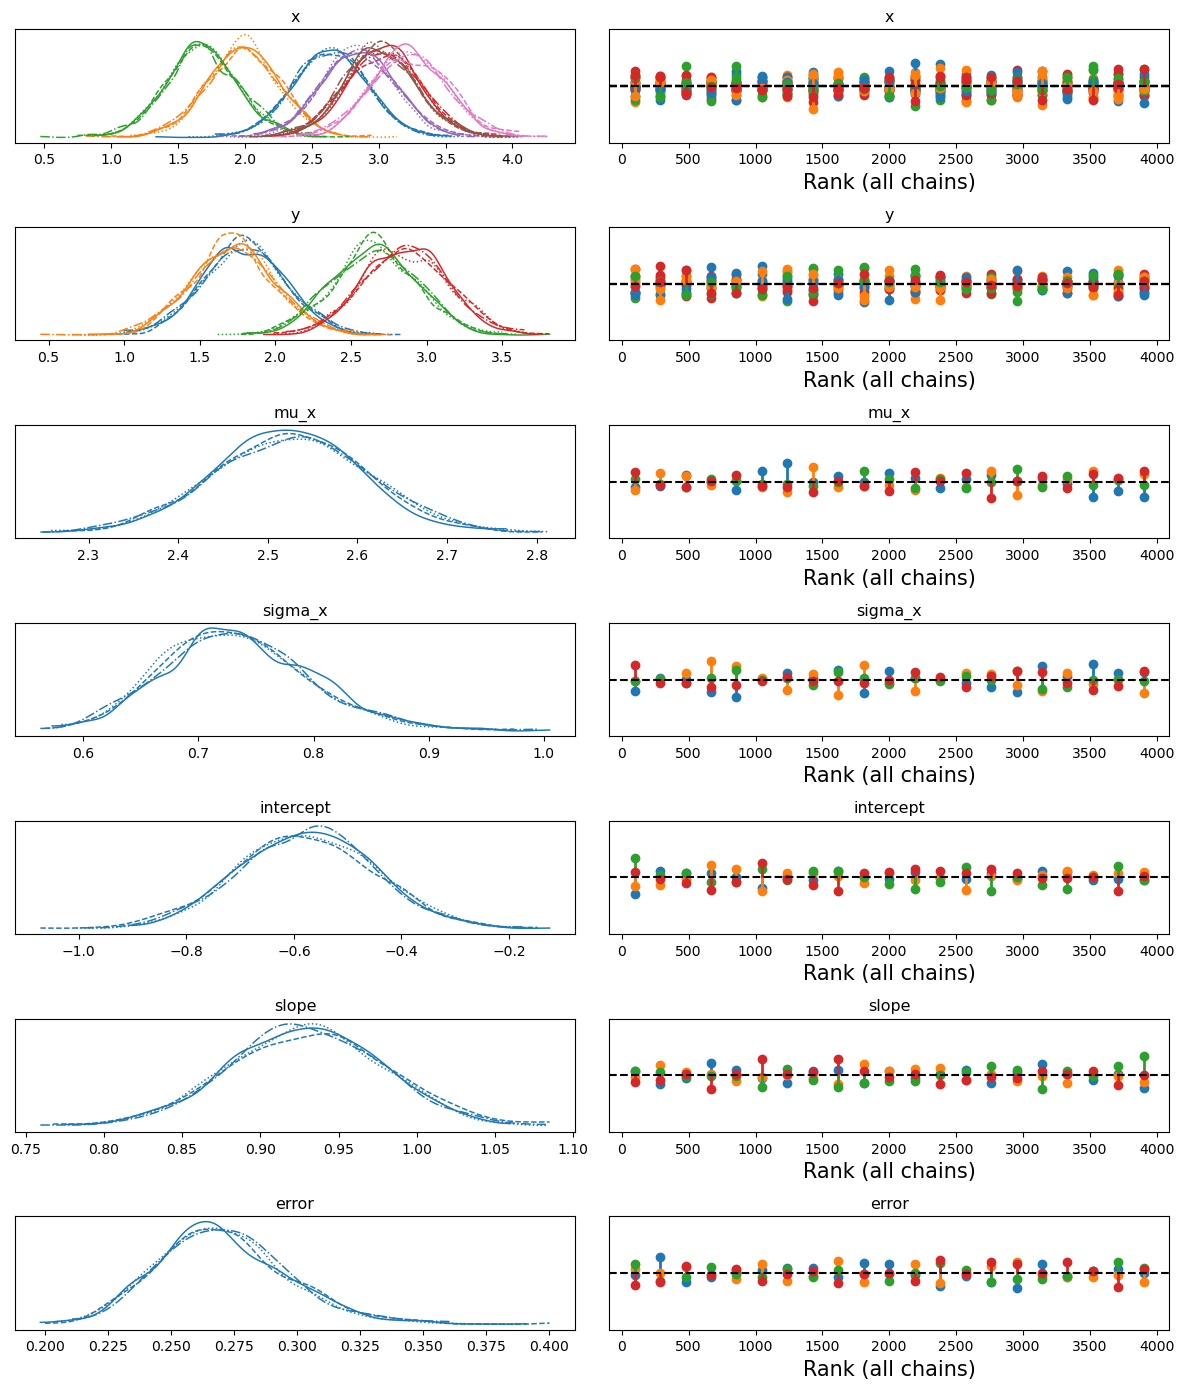

In [14]:
from matplotlib import pyplot
import arviz

axes = arviz.plot_trace(
    idata,
    kind='rank_vlines'
)

fig = axes[0, 0].get_figure()
fig.tight_layout()